# Goal: 

Use correlation to determine if there are relationships in the timing of lattice kinematics accross trials. 

The paucity of consistent patterns visible by eye leads us to consider using a random forest to predict lattice spacing change from the other lattice kinematics. 

Additionally, if the correlation of the 7.3 nm reflection and 14.4 nm reflection were high and consistent, without time lag, we'd expect that the 7.3 nm was dominated by the second order harmonic of the 14.4. 


In [1]:
import numpy as np
import pandas
import glob
import scipy.io
import math
from scipy import fftpack
import itertools
import math
import seaborn as sns

# Plot parameters 
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

color_map = 'inferno'

In [2]:
# import the results of the permutation bootstrap, which indicate if for a given trial, a datatype had a 5% chance or less of containing a the power at wingbeat frequency that it did upon random shuffle
perm_bootstrap = pandas.read_csv('Perm_bootstrap.csv')

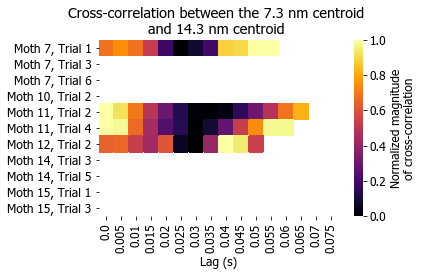

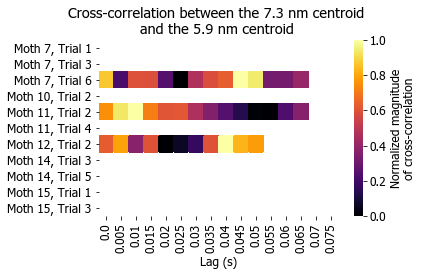

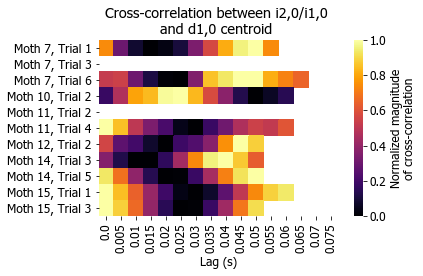

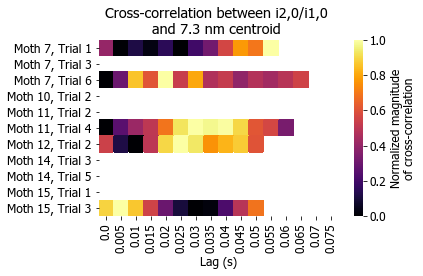

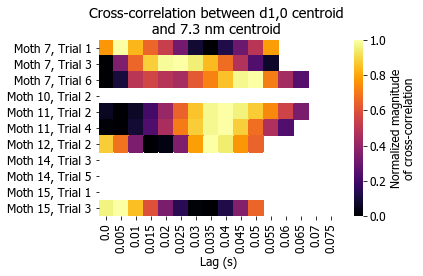

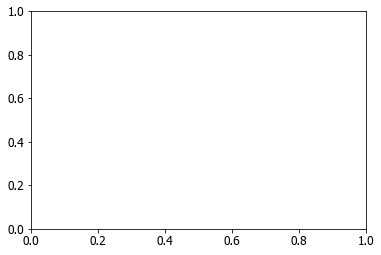

In [8]:
# Correlations with actual time lags and normalizing all of the magnitudes to 0-1

font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

number_of_lags = 16
cor_info = {'M6_cM3_c': ['the 7.3 nm centroid', '14.3 nm centroid'], 'M6_cA59_c': ['the 7.3 nm centroid', 'the 5.9 nm centroid'], 'I20_I10D10':['i2,0/i1,0', 'd1,0 centroid'], 'I20_I10M6_c':['i2,0/i1,0', '7.3 nm centroid'], 'D10M6_c':['d1,0 centroid','7.3 nm centroid']}

for pair in [['M6_c', 'M3_c'],['M6_c', 'A59_c'], ['I20_I10', 'D10'],['I20_I10', 'M6_c'], ['D10', 'M6_c']]:
    stored = pandas.DataFrame(np.zeros([number_of_lags, len(perm_bootstrap.Trial)])*np.nan, index=[np.arange(0,number_of_lags)*(1/200)], columns=perm_bootstrap.Trial)
    for trial in perm_bootstrap.Trial:
        df = pandas.read_csv('../DataProcessing/ProcessedData/' + trial + '_det.csv')
        df = df.interpolate(limit_direction = 'both').dropna(how = 'any') # Because if there are any NaNs, the correlation will be a NaN. Need to look into that dropnans
        len_ISI = math.ceil(len(df)/df.ISI.max()) # This is an approximate. This is the number of lags to calculate over. 
        df=(df-df.min())/(df.max()-df.min())

        if int(perm_bootstrap.where(perm_bootstrap.Trial == trial).dropna(how = 'all')[pair[0]]) < 5 and int(perm_bootstrap.where(perm_bootstrap.Trial == trial).dropna(how = 'all')[pair[1]]) < 5 :
            a = df[pair[0]]
            b = df[pair[1]]
            for i in np.arange(0, len_ISI):
                if i == 0:
                    c = np.correlate(a,b,mode = 'valid')
                else:
                    b1 = np.concatenate((b[-i:len(b)], b[0:len(b)-i]))
                    c = np.correlate(a,b1,mode = 'valid')
                #plt.scatter(i, c, c = 'black')
                stored[trial][i] = c
                
        else:
            for i in np.arange(0, len_ISI):
                stored[trial][i] = np.nan
        

    norm_stored = (stored-stored.min())/(stored.max()-stored.min())
    norm_stored = norm_stored.T
    norm_stored.index = np.array(['Moth 7, Trial 1', 'Moth 7, Trial 3', 'Moth 7, Trial 6', 'Moth 10, Trial 2', 'Moth 11, Trial 2', 'Moth 11, Trial 4', 'Moth 12, Trial 2', 'Moth 14, Trial 3', 'Moth 14, Trial 5', 'Moth 15, Trial 1', 'Moth 15, Trial 3'])
    ax = sns.heatmap(norm_stored, cmap = color_map, cbar_kws={'label': 'Normalized magnitude\nof cross-correlation'})
    ax.set(xlabel='Lag (s)', title = 'Cross-correlation between ' + cor_info[pair[0]+pair[1]][0] + ' \nand ' + cor_info[pair[0]+pair[1]][1] + ' ')
    plt.tight_layout()
    plt.savefig('/Users/Sage/Desktop/Correlations/Cor_'+pair[0]+pair[1]+'.png', dpi = 350)
    plt.show()
    plt.cla()

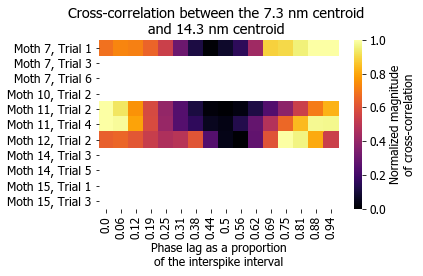

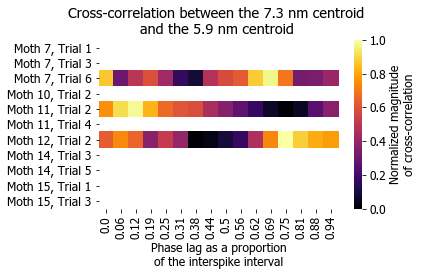

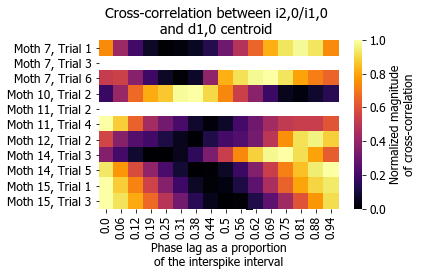

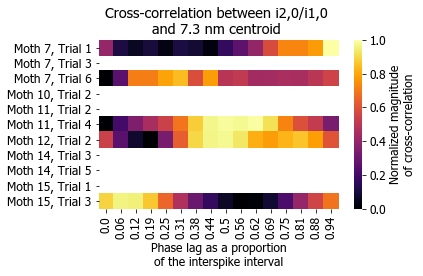

In [4]:
# Correlation with normalized ISI percent lag; normalized correlation magnitude

#cor_info = {'M6_cM3_c': ['the 7.3 nm repeat', '14.4 nm repeat'], 'M6_cA59_c': ['the 7.3 nm repeat', 'the 5.9 nm repeat'], 'I20_I10D10':['cross bridge recruitment', 'lattice spacing'], 'I20_I10M6_c':['cross bridge recruitment', '7.3 nm repeat']}
cor_info = {'M6_cM3_c': ['the 7.3 nm centroid', '14.3 nm centroid'], 'M6_cA59_c': ['the 7.3 nm centroid', 'the 5.9 nm centroid'], 'I20_I10D10':['i2,0/i1,0', 'd1,0 centroid'], 'I20_I10M6_c':['i2,0/i1,0', '7.3 nm centroid'], 'D10M6_c':['d1,0 centroid','7.3 nm centroid']}

for pair in [['M6_c', 'M3_c'], ['M6_c', 'A59_c'], ['I20_I10', 'D10'],['I20_I10', 'M6_c']]:
    for trial in perm_bootstrap.Trial:
        df = pandas.read_csv('../DataProcessing/ProcessedData/' + trial + '_det.csv')
        df = df.interpolate(limit_direction = 'both')#.dropna(how = 'any') # Because if there are any NaNs, the correlation will be a NaN. Need to look into that dropnans
        len_ISI = math.ceil(len(df)/df.ISI.max()) # This is an approximate. This is the number of lags to calculate over.
        
        df=(df-df.min())/(df.max()-df.min())

        if int(perm_bootstrap.where(perm_bootstrap.Trial == trial).dropna(how = 'all')[pair[0]]) < 5 and int(perm_bootstrap.where(perm_bootstrap.Trial == trial).dropna(how = 'all')[pair[1]]) < 5 :
            a = df[pair[0]]
            b = df[pair[1]]
            for i in np.arange(0, len_ISI):
                if i == 0:
                    c = np.correlate(a,b,mode = 'valid')
                else:
                    b1 = np.concatenate((b[-i:len(b)], b[0:len(b)-i]))
                    c = np.correlate(a,b1,mode = 'valid')
                plt.scatter(i, c, c = 'black')
                stored[trial][i] = c   
        else:
            for i in np.arange(0, len_ISI):
                stored[trial][i] = np.nan
        
    norm_stored = (stored-stored.min())/(stored.max()-stored.min())
    
    norm_stored_temp = norm_stored
    for i in norm_stored_temp:
        temp_ns = norm_stored_temp[i].dropna(how = 'all')
        
        # In order to normalize to proportion of ISI have to interpolate all time lagged data to be the same length
        try:
            x = np.linspace(0, number_of_lags, len(temp_ns))
            xvals = np.linspace(0, number_of_lags, number_of_lags)
            yinterp = np.interp(xvals, x, temp_ns)
        except: 
            yinterp = np.empty((number_of_lags))
            yinterp[:] = np.nan

        norm_stored_temp[i] = yinterp
    
    norm_stored_temp.reset_index(drop = True)
    norm_stored_temp.index = np.round(np.arange(0,1,1/len(norm_stored_temp)), 2)
    
    norm_stored_temp = norm_stored_temp.T
    norm_stored_temp.index = np.array(['Moth 7, Trial 1', 'Moth 7, Trial 3', 'Moth 7, Trial 6', 'Moth 10, Trial 2', 'Moth 11, Trial 2', 'Moth 11, Trial 4', 'Moth 12, Trial 2', 'Moth 14, Trial 3', 'Moth 14, Trial 5', 'Moth 15, Trial 1', 'Moth 15, Trial 3'])
    
    ax = sns.heatmap(norm_stored_temp, xticklabels = True, cmap = color_map, cbar_kws={'label': 'Normalized magnitude\nof cross-correlation'})
    ax.set(xlabel='Phase lag as a proportion\nof the interspike interval', title = 'Cross-correlation between ' + cor_info[pair[0]+pair[1]][0] + ' \nand ' + cor_info[pair[0]+pair[1]][1] + ' ')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.tight_layout()
    plt.savefig('/Users/Sage/Desktop/Correlations/NormCor_'+pair[0]+pair[1]+'.png', dpi = 350)
    plt.show()
    

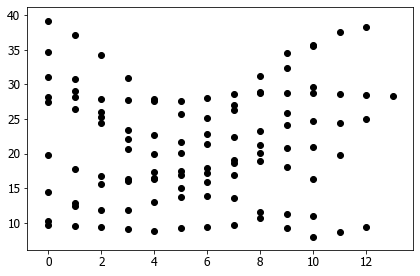

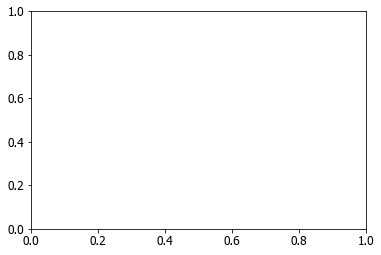

In [9]:
# Correlations with actual time lags and normalizing all of the magnitudes to 0-1

font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

number_of_lags = 16
cor_info = {'M6_cM3_c': ['the 7.3 nm centroid', '14.3 nm centroid'], 'M6_cA59_c': ['the 7.3 nm centroid', 'the 5.9 nm centroid'], 'I20_I10D10':['i2,0/i1,0', 'd1,0 centroid'], 'I20_I10M6_c':['i2,0/i1,0', '7.3 nm centroid'], 'D10M6_c':['d1,0 centroid','7.3 nm centroid']}

for pair in [['I20_I10', 'D10']]:#[['M6_c', 'M3_c'],['M6_c', 'A59_c'], ['I20_I10', 'D10'],['I20_I10', 'M6_c'], ['D10', 'M6_c']]:
    stored = pandas.DataFrame(np.zeros([number_of_lags, len(perm_bootstrap.Trial)])*np.nan, index=[np.arange(0,number_of_lags)*(1/200)], columns=perm_bootstrap.Trial)
    for trial in perm_bootstrap.Trial:
        df = pandas.read_csv('../DataProcessing/ProcessedData/' + trial + '_det.csv')
        df = df.interpolate(limit_direction = 'both').dropna(how = 'any') # Because if there are any NaNs, the correlation will be a NaN. Need to look into that dropnans
        len_ISI = math.ceil(len(df)/df.ISI.max()) # This is an approximate. This is the number of lags to calculate over. 
        df=(df-df.min())/(df.max()-df.min())

        if int(perm_bootstrap.where(perm_bootstrap.Trial == trial).dropna(how = 'all')[pair[0]]) < 5 and int(perm_bootstrap.where(perm_bootstrap.Trial == trial).dropna(how = 'all')[pair[1]]) < 5 :
            a = df[pair[0]]
            b = df[pair[1]]
            for i in np.arange(0, len_ISI):
                if i == 0:
                    c = np.correlate(a,b,mode = 'valid')
                else:
                    b1 = np.concatenate((b[-i:len(b)], b[0:len(b)-i]))
                    c = np.correlate(a,b1,mode = 'valid')
                plt.scatter(i, c, c = 'black')
                stored[trial][i] = c
                
        else:
            for i in np.arange(0, len_ISI):
                stored[trial][i] = np.nan
        

    #norm_stored = (stored-stored.min())/(stored.max()-stored.min())
    #norm_stored = norm_stored.T
    #norm_stored.index = np.array(['Moth 7, Trial 1', 'Moth 7, Trial 3', 'Moth 7, Trial 6', 'Moth 10, Trial 2', 'Moth 11, Trial 2', 'Moth 11, Trial 4', 'Moth 12, Trial 2', 'Moth 14, Trial 3', 'Moth 14, Trial 5', 'Moth 15, Trial 1', 'Moth 15, Trial 3'])
    #ax = sns.heatmap(norm_stored, cmap = color_map, cbar_kws={'label': 'Normalized magnitude\nof cross-correlation'})
    #ax.set(xlabel='Lag (s)', title = 'Cross-correlation between ' + cor_info[pair[0]+pair[1]][0] + ' \nand ' + cor_info[pair[0]+pair[1]][1] + ' ')
    plt.tight_layout()
    #plt.savefig('/Users/Sage/Desktop/Correlations/Cor_'+pair[0]+pair[1]+'.png', dpi = 350)
    plt.show()
    plt.cla()

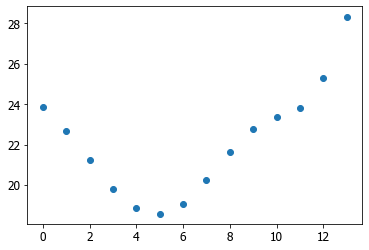

In [19]:
plt.scatter(np.arange(0,len(stored.T.mean())), stored.T.mean())

In [47]:
minmax = []
normed = stored.T
for i in np.arange(0,len(stored.T)):
    minmax.append([stored.T.iloc[i].min(), stored.T.iloc[i].max()])
    normed.iloc[i] = (stored.T.iloc[i] - stored.T.iloc[i].min())/stored.T.iloc[i].max()
    

In [48]:
normed = normed.reset_index(drop = 'True')

In [50]:
for i in np.arange(0,len(normed)):
    plt.scatter(np.arange(0,len(normed.iloc[i]), normed.iloc[i]))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().